In [209]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyalgotrade.barfeed import csvfeed
from pyalgotrade.bar import Frequency
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

<div class="jumbotron">
    <p class="display-1 h1">量化交易模型评估</p>
    <hr class="my-4">
    <p>主讲：李岩</p>
    <p>管理学院</p>
    <p>liyan@cumtb.edu.cn</p>
</div>

<center><img src="./img/performance/performanceFramework.png" width=100%></center>

# 评估指标

##### 总盈利率

$$
    \text{总盈利率}=\frac{\text{期末权益}-\text{期初权益}}{\text{期初权益}}
$$

##### 当日收益率

$$
    \text{当日收益率}=\frac{\text{当日权益}+\text{当日出金}}{\text{昨日权益}+\text{昨日入金}}-1
$$

##### 当日净值

$$
    \text{当日净值}=1+\text{当日收益率}
$$

##### 累计净值

$$
    P=\Pi_{i=1}^n P_i
$$

- $P_i$为第$i$天的当日净值

##### 最大回撤

- 回撤：一个净值高点与下一个净值高点之间出现的最低点与高点之间的回落百分比

<center><img src="./img/performance/drawdown.png" width=100%></center>

$$
    \text{历史最大回撤率}=\max\{\frac{\text{历史最大累计净值}-\text{当日累计净值}}{\text{历史最大累计净值}}\}
$$

##### 夏普比率

$$
    \text{sharpe ratio}=\frac{E(R_p）-R_f}{\sigma_p}
$$

- $R_f$：无风险收益率
- $R_p$：投资组合的收益率
- $\sigma_p$：投资组合收益的标准差

# 样本内绩效

## 样本内数据

- 真实交易的历史数据

- 生成的模拟交易数据

- 基本面数据

## 回测框架

<center><img src="./img/performance/backtestFramework.png" width=100%></center>

### 事件驱动（event-driven）的回测框架

- 一个时间循环，依据市场当时的情况发出交易信号

- 优点
    - 更加趋于真实交易的回测，代码经过简单修正可以用于实盘交易
    - 灵活，可以回测复杂的交易逻辑
    - 可以避免**前瞻性偏差（lookahead bias）**

- 缺点
    - 代码量大
    - 回测速度慢

### 向量化（vectorized）回测框架

- 获取交易策略所需要的所有数据与指标，将其转换成向量，利用线性代数的方法回测

- 优势
    - 代码量小
    - 回测速度快

- 缺点
    - 不灵活
    - 易于出现前瞻性偏差

### 当前主要的回测框架

##### `PyAlgoTrade`

- 事件驱动的回测框架
- 支持比特币的实盘交易
- 集成`TA-Lib`
- [http://gbeced.github.io/pyalgotrade/](http://gbeced.github.io/pyalgotrade/)

##### `Zipline`

- 事件驱动的回测框架
- Quantopian基于该框架开发了云计算支持的回测
- 用户规模大
- [https://www.zipline.io](https://www.zipline.io)

##### `Backtrader`

- 事件驱动型和向量型回测框架
- 支持实盘交易（国外）
- [https://www.backtrader.com](https://www.backtrader.com)

##### `backtesting.py`

- 事件驱动型回测框架
- 交互式图表
- [https://github.com/kernc/backtesting.py](https://github.com/kernc/backtesting.py)

##### `Vn.py`

- 事件驱动型回测框架
- 支持`CTP`实盘交易
- 国内开发的回测框架
- [https://www.vnpy.com](https://www.vnpy.com)

## `PyAlgoTrade`

- 中文文档 [https://pyalgotrade-docs-zh-cn.readthedocs.io/zh_CN/latest/tutorial.html](https://pyalgotrade-docs-zh-cn.readthedocs.io/zh_CN/latest/tutorial.html)

- 特点
    - 事件驱动型
    - 支持**市价(market)**、**限价(limit)**、**止损(stop)**等交易指令
    - 支持`csv`格式存储的时间序列数据
    - 集成`TA-Lib`
    - 支持`Bitcoin`交易
    - 支持实时`Twitter`事件分析

- 安装

```python
pip install pyalgotrade
```

cross_above shares, 8
cross_below 3424.0 3424.0 2019-12-05 14:44:00
length 30 3424.0
onExitOk 0
cross_above shares, 8
cross_below 3407.0 3407.0 2019-12-05 21:35:00
length 83 3407.0
onExitOk 0
cross_above shares, 8
cross_below 3407.0 3407.0 2019-12-05 21:39:00
length 87 3407.0
onExitOk 0
cross_above shares, 8
cross_below 3404.0 3404.0 2019-12-05 21:54:00
length 102 3404.0
onExitOk 0
cross_above shares, 8
cross_below 3404.0 3404.0 2019-12-05 22:01:00
length 109 3404.0
onExitOk 0
cross_above shares, 8
cross_below 3403.0 3403.0 2019-12-05 22:17:00
length 125 3403.0
onExitOk 0
cross_above shares, 8
cross_below 3405.0 3405.0 2019-12-05 22:23:00
length 131 3405.0
onExitOk 0
cross_above shares, 8
cross_below 3403.0 3403.0 2019-12-05 22:27:00
length 135 3403.0
onExitOk 0
cross_above shares, 8
cross_below 3405.0 3405.0 2019-12-06 09:10:00
length 179 3405.0
onExitOk 0
cross_above shares, 8
cross_below 3406.0 3406.0 2019-12-06 09:12:00
length 181 3406.0
onExitOk 0
cross_above shares, 8
cross_below

2020-10-14 21:42:08,277 strategy [INFO] 最终投资组合价值: $88868.00


cross_above shares, 6
cross_below 3819.0 3819.0 2020-08-31 11:11:00
length 1024 3819.0
onExitOk 0
cross_above shares, 6
cross_below 3818.0 3818.0 2020-08-31 11:16:00
length 1024 3818.0
onExitOk 0
cross_above shares, 6
cross_below 3820.0 3820.0 2020-08-31 11:27:00
length 1024 3820.0
onExitOk 0
cross_above shares, 6
cross_below 3819.0 3819.0 2020-08-31 13:50:00
length 1024 3819.0
onExitOk 0
cross_above shares, 6
cross_below 3819.0 3819.0 2020-08-31 14:02:00
length 1024 3819.0
onExitOk 0
cross_above shares, 6
cross_below 3820.0 3820.0 2020-08-31 14:09:00
length 1024 3820.0
onExitOk 0
cross_above shares, 6
cross_below 3821.0 3821.0 2020-08-31 14:18:00
length 1024 3821.0
onExitOk 0
cross_above shares, 6
cross_below 3821.0 3821.0 2020-08-31 14:21:00
length 1024 3821.0
onExitOk 0
cross_above shares, 6
cross_below 3821.0 3821.0 2020-08-31 14:46:00
length 1024 3821.0
onExitOk 0
cross_above shares, 6
cross_below 3818.0 3818.0 2020-08-31 15:00:00
length 1024 3818.0
onExitOk 0
cross_above shares, 

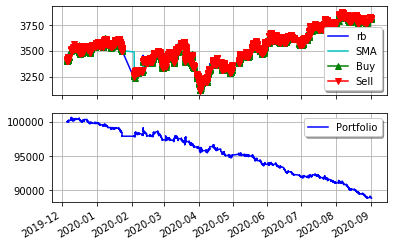

In [145]:
from pyalgotrade import strategy # 策略
from pyalgotrade import plotter # 做图
from pyalgotrade.technical import ma # 技术方法
from pyalgotrade.technical import cross # 技术方法
from pyalgotrade.stratanalyzer import returns # 评价
from pyalgotrade.stratanalyzer import sharpe
from pyalgotrade.stratanalyzer import drawdown
from pyalgotrade.stratanalyzer import trades
from pyalgotrade.barfeed import membf,csvfeed
from pyalgotrade import bar
# import tushare as ts
import pandas as pd

class MyStrategy(strategy.BacktestingStrategy): # 继承策略的父类
    def __init__(self, feed, instrument, smaPeriod):
        super(MyStrategy, self).__init__(feed,100000)
        self.__instrument = instrument
        self.__closed = feed.getDataSeries().getCloseDataSeries()
        self.__ma = ma.SMA(self.__closed, smaPeriod)
        self.__position = None
       
    def getSMA(self):
        return self.__ma
   
    def onEnterCanceled(self, position):
        self.__position = None
        print("onEnterCanceled", position.getShares())
       
    def onExitOk(self, position):
        self.__position = None
        print("onExitOk", position.getShares())
       
    def onExitCanceled(self, position):
        self.__position.exitMarket()
        print("onExitCanceled", position.getShares())
       
    # 这个函数每天调一次
    def onBars(self, bars):
        bar = bars[self.__instrument] # bar是k线中的每个柱
        if self.__position is None: 
            if cross.cross_above(self.__closed, self.__ma) > 0:
                shares = int(self.getBroker().getCash() * 0.3 / bar.getPrice())
                print("cross_above shares,", shares)
                self.__position = self.enterLong(self.__instrument, shares, True)
        elif not self.__position.exitActive() and cross.cross_below(self.__closed, self.__ma) > 0:
            print("cross_below", bar.getPrice(), bar.getClose(), bar.getDateTime())
            # print(bars.keys())
            print("length", len(self.__closed), self.__closed[-1])
            self.__position.exitMarket()

    def getClose(self):
        return self.__closed

code = 'rb'
feed = csvfeed.GenericBarFeed(bar.Frequency.MONTH)
feed.addBarsFromCSV(code,'./data/performance/rb.csv')


myStrategy = MyStrategy(feed, code, 20) # 最重要的策略类
plt = plotter.StrategyPlotter(myStrategy) # 做图分析
plt.getInstrumentSubplot(code).addDataSeries("SMA", myStrategy.getSMA())

retAnalyzer = returns.Returns() # 评价
myStrategy.attachAnalyzer(retAnalyzer)
sharpeRatioAnalyzer = sharpe.SharpeRatio()
myStrategy.attachAnalyzer(sharpeRatioAnalyzer)
drawDownAnalyzer = drawdown.DrawDown()
myStrategy.attachAnalyzer(drawDownAnalyzer)
tradesAnalyzer = trades.Trades()
myStrategy.attachAnalyzer(tradesAnalyzer)

myStrategy.run() # 开始运行，然后事件驱动
myStrategy.info("最终投资组合价值: $%.2f" % myStrategy.getResult())

print("最终资产价值: $%.2f" % myStrategy.getResult())
print("累计回报率: %.2f %%" % (retAnalyzer.getCumulativeReturns()[-1] * 100))
print("夏普比率: %.2f" % (sharpeRatioAnalyzer.getSharpeRatio(0.05)))
print("最大回撤率: %.2f %%" % (drawDownAnalyzer.getMaxDrawDown() * 100))
print("最长回撤时间: %s" % (drawDownAnalyzer.getLongestDrawDownDuration()))

print("")
print("总交易 Total trades: %d" % (tradesAnalyzer.getCount()))
if tradesAnalyzer.getCount() > 0:
    profits = tradesAnalyzer.getAll()
    print("利润", "mean", round(profits.mean(),2), "std", round(profits.std(),2),
          "max", round(profits.max(),2), "min", round(profits.min(),2))
    returns = tradesAnalyzer.getAllReturns()
    print("收益率", "mean", round(returns.mean(),2), "std", round(returns.std(),2),
          "max", round(returns.max(),2), "min", round(returns.min(),2))
print("")
print("赢利交易 Profitable trades: %d" % (tradesAnalyzer.getProfitableCount()))
if tradesAnalyzer.getProfitableCount() > 0:
    profits = tradesAnalyzer.getProfits()
    print("利润", "mean", round(profits.mean(),2), "std", round(profits.std(),2),
          "max", round(profits.max(),2), "min", round(profits.min(),2))
    returns = tradesAnalyzer.getPositiveReturns()
    print("收益率", "mean", round(returns.mean(),2), "std", round(returns.std(),2),
          "max", round(returns.max(),2), "min", round(returns.min(),2))
print("")
print("亏损交易Unprofitable trades: %d" % (tradesAnalyzer.getUnprofitableCount()))
if tradesAnalyzer.getUnprofitableCount() > 0:
    losses = tradesAnalyzer.getLosses()
    print("利润", "mean", round(losses.mean(),2), "std", round(losses.std(),2),
          "max", round(losses.max(),2), "min", round(losses.min(),2))
    returns = tradesAnalyzer.getNegativeReturns()
    print("收益率", "mean", round(returns.mean(),2), "std", round(returns.std(),2),
          "max", round(returns.max(),2), "min", round(returns.min(),2))
  
plt.plot()

### `PyAlgoTrade`的组成

<center><img src="./img/performance/pyalgotrade.png" width=100%></center>

- 数据源：数据接口
    - k线历史价格数据
    - Twitter的数据源，将 Tiwtter 的事件整合进交易决策中

- 券商：负责执行交易指令

- 数据序列：管理时间序列数据的接口

- 技术指标：基于数据序列而生成的一系列技术指标

- 优化器：可以实现在一台计算的多个进程中，或者多台计算机中运行回测

### 策略

- 策略：实现交易逻辑的**类**

```python

from pyalgotrade import strategy
 
class MyStrategy(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument):
        super(MyStrategy, self).__init__(feed)
        self.__instrument = instrument
 
    def onBars(self, bars):# 每一个数据都会抵达这里，就像becktest中的next
        bar = bars[self.__instrument]
        self.info(bar.getClose())# 我们打印输出收盘价
```

#### 类与对象

- 面向对象编程（object oriented programming，OOP）：是一种程序设计思想。OOP把对象作为程序的基本单元，一个对象包含了数据和操作数据的函数

- 类是对象的抽象，对象是类的实例

##### 定义类

- 用`class`关键字

```python
class Student(object):
    pass
```

- 建立对象

```python
studentA = Student()
studentB = Student()
```

##### 定义属性 

In [11]:
class Student(object):
    def __init__(self,name,gender,math,english):
        self.name = name
        self.gender = gender
        self.mathScore = math
        self.englishScore = english
        self.grade = 0

- `def __init__(self)`：初始化函数，建立对象的时候调用该函数，`self`**必不可少**

###### 建立对象

In [12]:
studentA = Student('Mike','male',100,90)
studentB = Student('Suzen','female',80,95)

###### 调用属性

In [13]:
studentA.name
studentB.name
studentA.mathScore
studentB.grade

'Mike'

'Suzen'

100

0

##### 定义方法

In [14]:
class Student(object):
    def __init__(self,name,gender,math,english):
        self.name = name
        self.gender = gender
        self.mathScore = math
        self.englishScore = english
        self.grade = 0
    def total_score(self):
        self.grade = self.mathScore + self.englishScore

###### 建立对象

In [15]:
studentA = Student('Mike','male',100,90)
studentB = Student('Suzen','female',80,95)

###### 调用方法

In [16]:
studentA.total_score()
studentB.total_score()
studentA.grade
studentB.grade

190

175

##### 定义更多方法

In [17]:
class Student(object):
    def __init__(self,name,gender,math,english):
        self.name = name
        self.gender = gender
        self.mathScore = math
        self.englishScore = english
        self.grade = 0
        
    def total_score(self):
        self.grade = self.mathScore + self.englishScore
    
    def show_grade(self):
        print(f'{self.name}的总成绩是{self.grade}')

In [19]:
studentLst = []
studentLst.append(Student('Mike','male',100,90))
studentLst.append(Student('Suzen','female',80,95))

In [20]:
for each in studentLst:
    each.total_score()
    each.show_grade()

Mike的总成绩是190
Suzen的总成绩是175


#### 简单均线策略

- 如果分钟收盘价**向上突破**15分钟均线，建立**多头头寸**
- 如果分钟收盘价**向下突破**15分钟均线，并且**已经有多头仓位**，那么**平掉该多头仓位**

##### 建立策略类

```python
from pyalgotrade import strategy
from pyalgotrade.technical import ma
```

###### 定义属性

```python
class MyStrategy(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument, smaPeriod):
        super(MyStrategy, self).__init__(feed, 50000)
        self.__position = None
        self.__instrument = instrument
        self.__sma = ma.SMA(feed[instrument].getPriceDataSeries(),smaPeriod)
```

- 属性
    - `self.__position`：记录仓位
    - `self.__instrument`：交易品种
    - `self.__sma`：均线

###### 定义方法：产生交易信号

```python
def onBars(self,bars):
    pass
```

- 交易逻辑都要体现在该方法（函数）中
- 唯一参数`bars`：是一个字典，`key`是交易标的名称，`value`是当前的k线数据
- k线数据：`pyalgotrade.bar.Bar`类的对象，该类的方法包括
    - `getDateTime()`
    - `getOpen()`
    - `getHigh()`
    - `getLow()`
    - `getClose()`
    - `getVolume()`
    - `getTypicalPrice()`
    - `getPrice()`：收盘价

<center><img src="./img/performance/bars.png" width=100%></center>

- 属于同一个bars的所有bar的`Date Time`必须一样

```python
    def onBars(self,bars):
        # 当移动均值存在的时候运行，否则返回
        if self.__sma[-1] is None:
            return

        bar = bars[self.__instrument]  # 获取需要交易品种的当前k线数据
        if self.__position is None:   # 判断当前是否有仓位
            if bar.getPrice() > self.__sma[-1]:  # 建立多仓条件
                pass
        elif bar.getPrice() < self.__sma[-1]:  # 平多仓条件
            pass
```

- `self.__sma[-1]`：移动平均序列向前移动一个周期

> 避免前瞻性偏差

### 下单指令

#### 建仓

##### 建仓交互过程

<center><img src="./img/performance/enterPosSeq.svg" width=100%></center>

##### 建仓命令

```python
    Strategy.enterLong(instrument,quantity)
    Strategy.enterShort(instrument,quantity)
```

- `instrument`：`str`类型，交易品种名称
- `quantity`：`int`类型，下单的数量

- 执行市价单

- 返回的是一个仓位类型，`pyalgotrade.strategy.position.Position`

##### 持仓

- `pyalgotrade.strategy.position.Position`类，该类有如下方法

- `getShares()`：获取持仓的数量
    - 正整数：多头仓位
    - 负整数：空头仓位
    - 0：仓位已经平掉，或者处于挂单状态，还未成交

- `getReturn(includeComissions=True)`：截至到当前时点，该仓位的累积收益率

- `getPnL(includeCommissions=True)`：截至到当前时点，该仓位的收益和损失（Profit and Loss）

- `getEntryOrder()`：获得建立该仓位对应的下单

- `getExitOrder()`：获得平掉该仓位对应的下单

##### 建仓成功的回复

```python
Strategy.onEnterOK(Position)
```

- 需要自定义内容的函数

#### 平仓

##### 平仓交互过程

<center><img src="./img/performance/exitPosSeq.svg" width=80%></center>

##### 平仓命令

- `Position.exitMarket()`：用**市价单**平掉仓位

##### 把建仓命令和平仓命令应用到策略中

```python
    def onBars(self,bars):
        bar = bars[self.__instrument]  # 获取需要交易标的的当前k线数据
        if self.__position is None:   # 判断当前是否有仓位
            if bar.getPrice() > self.__sma[-1]:  # 建立多仓条件
                self.__position = self.enterLong(self.__instrument, 5)  # 建立多仓
        elif bar.getPrice() < self.__sma[-1]:  # 平多仓条件
            self.__position.exitMarket()  # 平仓
```

- 平仓之前还需要判断一下是否有平仓的挂单

```python
    def onBars(self,bars):
        bar = bars[self.__instrument]  # 获取需要交易标的的当前k线数据
        if self.__position is None:   # 判断当前是否有仓位
            if bar.getPrice() > self.__sma[-1]:  # 建立多仓条件
                self.__position = self.enterLong(self.__instrument, 5)       # 建立5手多单
        elif bar.getPrice() < self.__sma[-1] and not self.__position.exitActive():  # 平多仓条件 并且当前没有平仓的挂单
            self.__position.exitMarket()
```

##### 平仓成功的回复

```python
    Strategy.onExitOK(Position)
```

- 需要自定义的函数

#### 查询是否有挂单

##### 挂单

<center><img src="./img/performance/listing.jpg" width=100%></center>

##### 查询是否有挂单交互过程

<center><img src="./img/performance/listOrderSeq.svg" width=100%></center>

##### 查询挂单命令

```python
    # 查询是否有开仓挂单
    Position.entryActive()
    # 查询是否有平仓挂单
    Position.exitActive()
```

- 如果有建仓（平仓）的挂单，返回`True`，否则为`False`

#### 查询下单是否成交

##### 查询下单是否成交交互过程

<center><img src="./img/performance/filledOrderSeq.svg" width=100%></center>

##### 查询是否成交命令

```python
    # 查询开仓单是否成交
    Position.entryFilled()
    # 查询平仓单是否成交
    Position.exitFilled()
```

- 如果建仓（平仓）的挂单已经成交，返回`True`，否则为`False`

#### 撤销下单

##### 撤单交互过程

<center><img src="./img/performance/cancelOrderSeq.svg" width=100%></center>

##### 撤单命令


```python
    # 撤销开仓单
    Position.cancelEntry()
    # 撤销平仓单
    Position.cancelExit()
```

##### 撤单回复

```python
    # 撤销开仓单的回复
    Strategy.onEnterCanceled(Position)
    # 撤销平仓单的回复
    Strategy.onExitCanceled(Position)
```

- 均是需要自定义的函数

### 券商

- 下单管理模块

#### `pyalgotrade.broker.Order`类

- 该类的方法
    - `getType()`：获取该订单的类型，包括市价单(MARKET)、限价单(LIMIT)、止损单(STOP)等
    - `getAction()`：获取该订单执行的方向，包括BUY、BUY_TO_COVER、SELL、SELL_SHORT
    - `getState()`：获取该订单的状态，包括提交(SUBMITTED)、被交易所接收(ACCEPTED)、撤销(CANCELED)、成交(FILLED)等
    - `getExecutionInfo()`：获取订单的执行信息，返回`pyalgotrade.broker.OrderExecutionInfo`类的对象

#### `pyalgotrade.broker.OrderExecutionInfo`类

- 该类的方法
    - `getPrice()`：实际成交价格
    - `getQuantity()`：实际成交数量

#### 自定义开仓成功和平仓成功函数

```python
    def onEnterOK(self, position):
        execInfo = position.getEntryOrder().getExecutionInfo()
        self.info(f'建多仓，价格为{execInfo.getPrice()：.2f}，数量为{execInfo.getQuantity()}')
```

```python
    def onExitOK(position):
        execInfo = position.getExitOrder().getExecutionInfo()
        self.info(f'平多仓，价格为{execInfo.getPrice():.2f}，数量为{execInfo.getQuantity()}')
        self.__position = None   # 清空仓位
```

#### 完整策略

```python
    from pyalgotrade import strategy
    from pyalgotrade.technical import ma
    
    class MyStrategy(strategy.BacktestingStrategy):
        def __init__(self, feed, instrument, smaPeriod):
            super(MyStrategy, self).__init__(feed, 50000)
            self.__position = None
            self.__instrument = instrument
            self.__sma = ma.SMA(feed[instrument].getPriceDataSeries(), smaPeriod)

        def onEnterOk(self, position):
            execInfo = position.getEntryOrder().getExecutionInfo()
            self.info(f'建多仓，价格为{execInfo.getPrice():.2f}，数量为{execInfo.getQuantity()}')

        def onExitOk(self, position):
            execInfo = position.getExitOrder().getExecutionInfo()
            self.info(f'平多仓，价格为{execInfo.getPrice():.2f}，数量为{execInfo.getQuantity()}')
            self.__position = None

        def onBars(self, bars):
            if self.__sma[-1] is None:
                return

            bar = bars[self.__instrument]
            if self.__position is None:
                if bar.getPrice() > self.__sma[-1]:
                    self.__position = self.enterLong(self.__instrument, 5)
            elif bar.getPrice() < self.__sma[-1] and not self.__position.exitActive():
                self.__position.exitMarket()
```

### 数据源

- `feed`类实现数据源管理，主要功能包括：
    - 读取`csv`格式存储的交易数据
    - 在策略的事件循环中产生新的数据

#### 生成`feed`类

```python
    pyalgotrade.barfeed.csvfeed.GenericBarFeed(frequency)
```
- 从`csv`文件中读入数据

- 要求`csv`文件中数据要求满足下列格式

Date Time|Open|High|Low|Close|Volume|Adj Close
---|---|---|---|---|---|---
2020-10-10 14:32:00|3600|3700|3480|3650|112|

- `frequency`：K线的时间长度，可以取值`SECOND,MINUTE,HOUR,DAY,WEEK,MONTH`

- 建立一个读取`csv`文件的`feed`类
```python
    from pyalgotrade.barfeed import csvfeed
    feed = csvfeed.GenericBarFeed(Frequency.MINUTE)
```

#### 加载数据

- `feed`类的方法
```python
   addBarsFromCSV(instrument,path)
```
- `instrument`：标的的名称
- `path`：数据文件的路径

- 给建立的`feed`类的对象加载`rb`的交易数据

```python
    feed.addBarsFromCSV('rb','./data/performance/rb.csv')
```

In [101]:
myfeed = csvfeed.GenericBarFeed(Frequency.MINUTE)

In [102]:
type(myfeed)

pyalgotrade.barfeed.csvfeed.GenericBarFeed

In [103]:
myfeed.addBarsFromCSV('rb','./data/performance/rb.csv')

#### 获取k线序列

```python
    feed[instrument]
```
- 返回的是`pyalgotrade.dataseries.bards.BarDataSeries`类的对象

In [150]:
type(myfeed['rb'])

pyalgotrade.dataseries.bards.BarDataSeries

- 该类的主要方法
    - `getCloseDataSeries()`
    - `getHighDataSeries()`
    - `getLowDataSeries()`
    - `getOpenDataSeries()`
    - `getVolumeDataSeries()`
- 均返回的是`pyalgotrade.dataseries.DataSeries`类的对象

<center><img src="./img/performance/barDataSeries.png" width=100%></center>

### 技术分析

#### 趋势指标

```python
    pyalgotrade.technical.ma.SMA(dataSeries, period)
```
- 简单移动平均
- `dataSeries`：***`DataSeries`***类的数据序列
- `period`：时间窗口长度

```python
    pyalgotrade.technical.ma.EMA(dataSeries, period)
```
- 指数移动平均
- `dataSeries`：***`DataSeries`***类的数据序列
- `period`：时间窗口长度

```python
    pyalgotrade.technical.ma.VWAP(dataSeries, period)
```
- 成交量加权的移动平均
- `dataSeries`：***`BarDataSeries`***类的数据序列
- `period`：时间窗口长度

```python
    pyalgotrade.technical.macd.MACD(dataSeries, fastEMA, slowEMA, signalEMA)
```
- `dataSeries`：***`DataSeries`***类的数据序列
- `fastEMA`：短期时间窗口长度
- `slowEMA`：长期时间窗口长度
- `signalEMA`：信号线时间窗口长度

- 方法
    - `getHistogram()`：获得`MACD`线与`Signal`线之间的差
    - `getSignal()`：获得信号线的`DataSeries`数据序列

#### 能量指标

```python
    pyalgotrade.technical.rsi.RSI(dataSeries, period)
```
- `dataSeries`：***`DataSeries`***类的数据序列
- `period`：时间窗口长度

#### 波动性指标

```python
    pyalgotrade.technical.atr.ATR(barDataSeries, period)
```
- `barDataSeries`：***`BarDataSeries`***类的数据序列
- `period`：时间窗口长度

```python
    pyalgotrade.technical.bollinger.BollingerBands(dataSeries, period，numStdDev)
```
- `dataSeries`：***`DataSeries`***类的数据序列
- `period`：时间窗口长度
- `numStdDev`：标准差的倍数

- 方法
    - `getLowerBand()`：获得Bollinger的下界
    - `getUpperBand()`：获得Bollinger的上界
    - `getMiddleBand()`：获得Bollinger的中线

#### 其他指标

```python
    pyalgotrade.technical.cross.cross_above(dataSeries1, dataSeries2)
```
- 检查两个数据序列的**向上**穿越条件
- `dataSeries1`：***`DataSeries`***类的数据序列，穿越的序列
- `dataSeries2`：***`DataSeries`***类的数据序列，被穿越的序列

```python
    pyalgotrade.technical.cross.cross_below(dataSeries1, dataSeries2)
```
- 检查两个数据序列的**向下**穿越条件
- `dataSeries1`：***`DataSeries`***类的数据序列，穿越的序列
- `dataSeries2`：***`DataSeries`***类的数据序列，被穿越的序列

```python
    pyalgotrade.technical.highlow.High(dataSeries, period)
```
- 计算时间窗口内的**最高值**
- `dataSeries`：***`DataSeries`***类的数据序列
- `period`：时间窗口长度

```python
    pyalgotrade.technical.highlow.Low(dataSeries, period)
```
- 计算时间窗口内的**最低值**
- `dataSeries`：***`DataSeries`***类的数据序列
- `period`：时间窗口长度

#### 调用`TA-Lib`

- 通过`pyalgotrade.talibext.indicator`实现对`TA-Lib`的调用

```python
    pyalgotrade.talibext.indicator.BBANDS(ds, count, matype)
```
- `ds`：***`DataSeries`***类的数据序列
- `count`：需要用到的数据数量

```python
    pyalgotrade.talibext.indicator.ATR(barDs, count, timeperiod)
```
- `barDs`：***`BarDataSeries`***类型的数据序列
- `count`：需要用到的数据数量
- `timeperiod`：时间窗口长度

### 运行策略

```python
    Strategy.run()
```
- 运行策略，仅能调用**一次**

- 建立策略类

In [217]:
from pyalgotrade import strategy
from pyalgotrade.technical import ma

class MyStrategy(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument, smaPeriod):
        super(MyStrategy, self).__init__(feed, 50000)
        self.__position = None
        self.__instrument = instrument
        self.__sma = ma.SMA(feed[instrument].getPriceDataSeries(), smaPeriod)

    def onEnterOk(self, position):
        execInfo = position.getEntryOrder().getExecutionInfo()
        self.info(f'建多仓，价格为{execInfo.getPrice():.2f}，数量为{execInfo.getQuantity()}')

    def onExitOk(self, position):
        execInfo = position.getExitOrder().getExecutionInfo()
        self.info(f'平多仓，价格为{execInfo.getPrice():.2f}，数量为{execInfo.getQuantity()}，PnL为{position.getPnL()}')
        self.__position = None

    def onBars(self, bars):
        if self.__sma[-1] is None:
            return

        bar = bars[self.__instrument]
        if self.__position is None:
            if bar.getPrice() > self.__sma[-1]:
                self.__position = self.enterLong(self.__instrument, 5)
        elif bar.getPrice() < self.__sma[-1] and not self.__position.exitActive():
            self.__position.exitMarket()

- 建立数据源并读入数据

In [223]:
from pyalgotrade.barfeed import csvfeed
from pyalgotrade.bar import Frequency
myfeed = csvfeed.GenericBarFeed(Frequency.MINUTE)
myfeed.addBarsFromCSV('rb','./data/performance/rb.csv')

- 建立策略对象并初始化

In [224]:
myStrategy = MyStrategy(myfeed,'rb',15)

- 运行策略

In [196]:
myStrategy.run()

2019-12-05 14:33:00 strategy [INFO] 建多仓，价格为3426.00，数量为5
2019-12-05 14:39:00 strategy [INFO] 平多仓，价格为3425.00，数量为5，PnL为-5.0
2019-12-05 14:44:00 strategy [INFO] 建多仓，价格为3426.00，数量为5
2019-12-05 14:45:00 strategy [INFO] 平多仓，价格为3423.00，数量为5，PnL为-15.0
2019-12-05 21:08:00 strategy [INFO] 建多仓，价格为3403.00，数量为5
2019-12-05 21:18:00 strategy [INFO] 平多仓，价格为3404.00，数量为5，PnL为5.0
2019-12-05 21:19:00 strategy [INFO] 建多仓，价格为3405.00，数量为5
2019-12-05 21:21:00 strategy [INFO] 平多仓，价格为3404.00，数量为5，PnL为-5.0
2019-12-05 21:23:00 strategy [INFO] 建多仓，价格为3405.00，数量为5
2019-12-05 21:36:00 strategy [INFO] 平多仓，价格为3407.00，数量为5，PnL为10.0
2019-12-05 21:39:00 strategy [INFO] 建多仓，价格为3408.00，数量为5
2019-12-05 21:40:00 strategy [INFO] 平多仓，价格为3407.00，数量为5，PnL为-5.0
2019-12-05 21:54:00 strategy [INFO] 建多仓，价格为3405.00，数量为5
2019-12-05 21:55:00 strategy [INFO] 平多仓，价格为3404.00，数量为5，PnL为-5.0
2019-12-05 22:01:00 strategy [INFO] 建多仓，价格为3405.00，数量为5
2019-12-05 22:13:00 strategy [INFO] 平多仓，价格为3405.00，数量为5，PnL为0.0
2019-12-05 22:17:00 strategy [INF

- 最终权益

```python
    Strategy.getResult()
```

In [181]:
myStrategy.getResult()

40685.0

### 绩效评估

- 利用`pyalgotrade.stratanalyzer`类进行策略评估

<center><img src="./img/performance/analyzer.png" width=100%></center>

#### 盈利状况

```python
    pyalgotrade.stratanalyzer.returns.Returns类
```

- `getReturns()`：计算每个k线(bar)的收益率

- `getCumulativeReturns()`：计算每个k线(bar)的累积收益率

#### 风险大小

```python
    pyalgotrade.stratanalyzer.drawdown.DrawDown类
```

- `getMaxDrawDown()`：获得**最大回撤**

- `getLongestDrawDownDuration()`：获得**持续时间最长**的回撤所经历的时间，两个高点之间时间距离最长

<center><img src="./img/performance/drawdownDuration.png" width=100%></center>

#### 盈利风险综合

```python
    pyalgotrade.stratanalyzer.sharpe.SharpeRatio类
```

- `getSharpeRatio(riskFreeRate)`：获得年化的Sharpe Ratio
    - `riskFreeRate`：无风险收益率，例如0.03

#### 逐笔交易统计

```python
    pyalgotrade.stratanalyzer.trades.Trades类
```

- `getCount()`：获得总交易次数

- `getProfitableCount()`：获得盈利交易的次数

- `getUnprofitableCount()`：获得亏损交易的次数

- `getEvenCount()`：获得既不盈利也不亏损的交易次数

- `getAll()`：获得每笔交易的PnL，是一个`numpy.array`

- `getAllReturns()`：获得每笔交易的收益率，是一个`numpy.array`

#### 加载绩效评估

```python
    Strategy.attachAnalyzer(strategyAnalyzer)
```
- `strategyAnalyzer`：各个绩效评估类的对象

- 例如：
```python
    from pyalgotrade.stratanalyzer import returns, drawdown, sharpe, trades
    retAnalyzer = returns.Returns()               # 建立收益率对象
    myStrategy.attachAnalyzer(retAnalyzer)        # 加载收益率对象到策略中
    
    drawDownAnalyzer = drawDown.DrawDown()        # 建立回撤对象
    myStrategy.attachAnalyzer(drawDownAnalyzer)   # 加载回撤对象到策略中
    
    sharpeAnalyzer = sharpe.SharpeRatio()         # 建立Sharpe Ratio对象
    myStrategy.attachAnalyzer(sharpeAnalyzer)     # 加载Sharpe Ratio对象到策略中

    tradeAnalyzer = trades.Trades()               # 建立逐笔交易统计对象
    myStrategy.attachAnalyzer(tradeAnalyzer)      # 加载逐笔交易统计对象到策略中
    
    myStrategy.run()                      # 策略运行
```

In [226]:
    from pyalgotrade.stratanalyzer import returns, drawdown, sharpe, trades
    retAnalyzer = returns.Returns()
    myStrategy.attachAnalyzer(retAnalyzer)
    
    drawDownAnalyzer = drawdown.DrawDown()
    myStrategy.attachAnalyzer(drawDownAnalyzer)
    
    sharpeAnalyzer = sharpe.SharpeRatio()
    myStrategy.attachAnalyzer(sharpeAnalyzer)

    tradeAnalyzer = trades.Trades()
    myStrategy.attachAnalyzer(tradeAnalyzer)

#### 显示绩效评估结果

##### 整体绩效

```python
    myStrategy.info(f'最终权益: {myStrategy.getResult():.2f}')
    print(f'累计回报率: {retAnalyzer.getCumulativeReturns()[-1] * 100:.2f}%')
    print(f'夏普比率: {sharpeAnalyzer.getSharpeRatio(0.05):.2f}%')
    print(f'最大回撤率: {drawDownAnalyzer.getMaxDrawDown() * 100:.2f}%')
    print(f'最长回撤时间: {drawDownAnalyzer.getLongestDrawDownDuration()}')
```

In [208]:
print(f'最终权益: {myStrategy.getResult():.2f}')
print(f'累计回报率: {retAnalyzer.getCumulativeReturns()[-1] * 100:.2f}%')
print(f'夏普比率: {sharpeAnalyzer.getSharpeRatio(0.05):.2f}%')
print(f'最大回撤率: {drawDownAnalyzer.getMaxDrawDown() * 100:.2f}%')
print(f'最长回撤时间: {drawDownAnalyzer.getLongestDrawDownDuration()}')

最终权益: 40685.00
累计回报率: -18.63%
夏普比率: -8.33%
最大回撤率: 19.22%
最长回撤时间: 267 days, 2:57:00


##### 逐笔绩效统计

```python
    totalTradeNums = tradeAnalyzer.getCount()
    print(f'总交易次数: {totalTradeNums}')
    if totalTradeNums > 0:
        print(f'交易胜率：{tradeAnalyzer.getProfitableCount()/totalTradeNums*100:.2f}%')
        
        profits = tradeAnalyzer.getAll()
        print(f'利润, 均值 {profits.mean():.2f}, 标准差{profits.std():.2f}, 最大值{profits.max():2f}, 最小值{profits.min():.2f}')
        
        returns = tradesAnalyzer.getAllReturns()
        print(f'收益率, 均值 {returns.mean()*100:.2f}%, 标准差{returns.std()*100:.2f}%, 最大值{returns.max()*100:.2f}%, 最小值{returns.min()*100:.2f}%')
```

In [215]:
totalTradeNums = tradeAnalyzer.getCount()
print(f'总交易次数: {totalTradeNums}')
if totalTradeNums > 0:
    print(f'交易胜率：{tradeAnalyzer.getProfitableCount()/totalTradeNums*100:.2f}%')

    profits = tradeAnalyzer.getAll()
    print(f'利润, 均值 {profits.mean():.2f}, 标准差{profits.std():.2f}, 最大值{profits.max():2f}, 最小值{profits.min():.2f}')

    returns = tradesAnalyzer.getAllReturns()
    print(f'收益率, 均值 {returns.mean()*100:.2f}%, 标准差{returns.std()*100:.2f}%, 最大值{returns.max()*100:.2f}%, 最小值{returns.min()*100:.2f}%')

总交易次数: 4802
交易胜率：19.85%
利润, 均值 -1.94, 标准差23.86, 最大值470.000000, 最小值-155.00
收益率, 均值 -0.01%, 标准差0.15%, 最大值2.81%, 最小值-1.06%


#### 绘图

```python
    pyalgotrade.plotter.StrategyPlotter(strat)类
```
- `strat`：建立的`Strategy`的对象

<center><img src="./img/performance/pyalgotradePlot.png" width=100%></center>

- 方法
    - `getInstrumentSubplot(instrument)`：得到交易标的的价格子图
        - `instrument`：交易标的名称

- 方法
    - `getOrCreateSubplot(name)`：得到一个子图，如果该子图不存在，则创建该子图
        - `name`：子图的名称
        - `addDataSeries(label, dataSeries)`：给创建的子图上添加数据序列

- 方法
    - `plot()`：绘制策略运行图，**必须在策略运行之后**调用

- 方法
    - `savePlot(fileName, dpi=None, format='png')`：保存绘制的策略图
        - `fileName`：保存图片的完整路径
        - `dpi`：每英寸点数（dots per inch）
        - `format`：图片格式

##### 调用绘图

```python
    from pyalgotrade import plotter
    # 建立绘制策略图类的对象
    myplt = plotter.StrategyPlotter(myStrategy)
    # 增加一个子图，绘制收益率图像
    myplt.getOrCreateSubplot('收益率').addDataSeries('Returns', retAnalyzer.getReturns())
    # 运行策略
    myStrategy.run()
    # 绘图
    myplot.plot()
```

#### 完整策略运行

##### 导入需要的包

In [168]:
from pyalgotrade import strategy
from pyalgotrade.technical import ma
from pyalgotrade.barfeed import csvfeed
from pyalgotrade.bar import Frequency
from pyalgotrade.stratanalyzer import returns, drawdown, sharpe, trades
from pyalgotrade import plotter

##### 建立策略

In [164]:
class MyStrategy(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument, smaPeriod):
        super(MyStrategy, self).__init__(feed, 50000)
        self.__position = None
        self.__instrument = instrument
        self.__sma = ma.SMA(feed[instrument].getPriceDataSeries(), smaPeriod)

    def onEnterOk(self, position):
        execInfo = position.getEntryOrder().getExecutionInfo()
        self.info(f'建多仓，价格为{execInfo.getPrice():.2f}，数量为{execInfo.getQuantity()}')

    def onExitOk(self, position):
        execInfo = position.getExitOrder().getExecutionInfo()
        self.info(f'平多仓，价格为{execInfo.getPrice():.2f}，数量为{execInfo.getQuantity()}')
        self.__position = None

    def onBars(self, bars):
        if self.__sma[-1] is None:
            return

        bar = bars[self.__instrument]
        if self.__position is None:
            if bar.getPrice() > self.__sma[-1]:
                self.__position = self.enterLong(self.__instrument, 5)
        elif bar.getPrice() < self.__sma[-1] and not self.__position.exitActive():
            self.__position.exitMarket()

##### 加载数据源

In [165]:
myfeed = csvfeed.GenericBarFeed(Frequency.MINUTE)
myfeed.addBarsFromCSV('rb','./data/performance/rb.csv')

##### 建立策略对象

In [166]:
myStrategy = MyStrategy(myfeed,'rb',1800)

##### 建立评估指标和绘图

In [169]:
retAnalyzer = returns.Returns()
myStrategy.attachAnalyzer(retAnalyzer)

drawDownAnalyzer = drawdown.DrawDown()
myStrategy.attachAnalyzer(drawDownAnalyzer)

sharpeAnalyzer = sharpe.SharpeRatio()
myStrategy.attachAnalyzer(sharpeAnalyzer)

tradeAnalyzer = trades.Trades()
myStrategy.attachAnalyzer(tradeAnalyzer)

myplt = plotter.StrategyPlotter(myStrategy)
myplt.getOrCreateSubplot('收益率').addDataSeries('Returns', retAnalyzer.getReturns())

##### 运行策略

In [170]:
myStrategy.run()

2019-12-12 21:03:00 strategy [INFO] 建多仓，价格为3525.00，数量为5
2019-12-13 10:44:00 strategy [INFO] 平多仓，价格为3506.00，数量为5
2019-12-13 10:46:00 strategy [INFO] 建多仓，价格为3507.00，数量为5
2019-12-16 09:57:00 strategy [INFO] 平多仓，价格为3524.00，数量为5
2019-12-16 09:58:00 strategy [INFO] 建多仓，价格为3526.00，数量为5
2019-12-16 10:01:00 strategy [INFO] 平多仓，价格为3521.00，数量为5
2019-12-16 10:02:00 strategy [INFO] 建多仓，价格为3525.00，数量为5
2019-12-16 10:05:00 strategy [INFO] 平多仓，价格为3516.00，数量为5
2019-12-19 13:31:00 strategy [INFO] 建多仓，价格为3521.00，数量为5
2019-12-24 11:25:00 strategy [INFO] 平多仓，价格为3509.00，数量为5
2019-12-24 13:36:00 strategy [INFO] 建多仓，价格为3509.00，数量为5
2019-12-24 13:37:00 strategy [INFO] 平多仓，价格为3508.00，数量为5
2019-12-24 13:38:00 strategy [INFO] 建多仓，价格为3509.00，数量为5
2019-12-24 13:40:00 strategy [INFO] 平多仓，价格为3505.00，数量为5
2019-12-24 13:46:00 strategy [INFO] 建多仓，价格为3509.00，数量为5
2019-12-24 14:14:00 strategy [INFO] 平多仓，价格为3509.00，数量为5
2019-12-24 14:16:00 strategy [INFO] 建多仓，价格为3511.00，数量为5
2019-12-24 21:32:00 strategy [INFO] 平多仓，价格为3510.

##### 显示结果

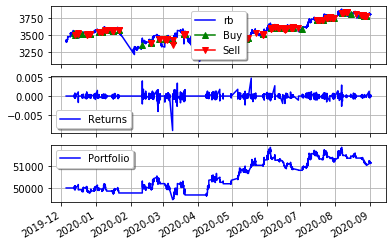

最终权益: 51120.00
累计回报率: 2.24%
夏普比率: -0.47
最大回撤率: 2.11%
最长回撤时间: 63 days, 5:05:00
总交易次数: 261
交易胜率：9.58%
利润, 均值 3.89, 标准差90.84, 最大值675.000000, 最小值-430.00
收益率, 均值 0.03%, 标准差0.53%, 最大值4.02%, 最小值-2.50%


In [171]:
myplt.plot()
totalTradeNums = tradeAnalyzer.getCount()
print(f'最终权益: {myStrategy.getResult():.2f}')
print(f'累计回报率: {retAnalyzer.getCumulativeReturns()[-1] * 100:.2f}%')
print(f'夏普比率: {sharpeAnalyzer.getSharpeRatio(0.05):.2f}')
print(f'最大回撤率: {drawDownAnalyzer.getMaxDrawDown() * 100:.2f}%')
print(f'最长回撤时间: {drawDownAnalyzer.getLongestDrawDownDuration()}')
print(f'总交易次数: {totalTradeNums}')
if totalTradeNums > 0:
    print(f'交易胜率：{tradeAnalyzer.getProfitableCount()/totalTradeNums*100:.2f}%')

    profits = tradeAnalyzer.getAll()
    print(f'利润, 均值 {profits.mean():.2f}, 标准差{profits.std():.2f}, 最大值{profits.max():2f}, 最小值{profits.min():.2f}')

    returns = tradeAnalyzer.getAllReturns()
    print(f'收益率, 均值 {returns.mean()*100:.2f}%, 标准差{returns.std()*100:.2f}%, 最大值{returns.max()*100:.2f}%, 最小值{returns.min()*100:.2f}%')

## 策略例子

### 基于布林线的均值回归策略

- 当收盘价低于布林线下界的时候，**平空仓**，**建多仓**
- 当收盘价超过布林线上界的时候，**平多仓**，**建空仓**

#### 导入需要的包

In [194]:
from pyalgotrade import strategy, plotter
from pyalgotrade.technical import bollinger
from pyalgotrade.stratanalyzer import returns, sharpe, trades, drawdown
from pyalgotrade.barfeed import csvfeed
from pyalgotrade.bar import Frequency

#### 建立策略

In [187]:
class myBBands(strategy.BacktestingStrategy):
    
    def __init__(self, feed, instrument, bBandsPeriod, numDev, initEquity):
        super(myBBands, self).__init__(feed, initEquity)
        self.__instrument = instrument
        self.__bbands = bollinger.BollingerBands(feed[instrument].getCloseDataSeries(), bBandsPeriod, numDev)
        self.__positivePosition = None
        self.__negativePosition = None

    def getBollingerBands(self):
        return self.__bbands
    
    def onExitOk(self, position):
        order = position.getExitOrder()
        execInfo = order.getExecutionInfo()
        self.info(f'{self.action_type(order)}，价格为{execInfo.getPrice():.2f}')
        if self.__negativePosition == position:
            self.__negativePosition = None
        elif self.__positivePosition == position:
            self.__positivePosition = None
        
    def onEnterOk(self, position):
        order = position.getEntryOrder()
        execInfo = order.getExecutionInfo()
        self.info(f'{self.action_type(order)}，价格为{execInfo.getPrice():.2f}')
        
    def action_type(self, order):
        actionType = order.getAction()
        typeMeaning = ''
        if actionType == 1:
            typeMeaning = '建多仓'
        elif actionType == 2:
            typeMeaning = '平空仓'
        elif actionType == 3:
            typeMeaning = '平多仓'
        elif actionType == 4:
            typeMeaning = '建空仓'
        return typeMeaning
            

    def onBars(self, bars):
        lower = self.__bbands.getLowerBand()[-1]
        upper = self.__bbands.getUpperBand()[-1]
        if lower is None:
            return

        bar = bars[self.__instrument]
        
        if bar.getClose() < lower:
            if self.__negativePosition is not None and self.__negativePosition.exitActive() is False:
                # 有空仓，并且没有平空仓的挂单
                self.__negativePosition.exitMarket()
            if self.__positivePosition is None:
                # 没有多仓
                self.__positivePosition = self.enterLong(self.__instrument, 5)
        elif bar.getClose() > upper:
            if self.__positivePosition is not None and self.__positivePosition.exitActive() is False:
                # 有多仓，并且没有平多仓的挂单
                self.__positivePosition.exitMarket()
            if self.__negativePosition is None:
                # 没有空仓
                self.__negativePosition = self.enterShort(self.__instrument, 5)

#### 设定评估指标

In [43]:
def strategy_evaluation(inputStrategy):
    retAnalyzer = returns.Returns()
    sharpeAnalyzer = sharpe.SharpeRatio()
    ddAnalyzer = drawdown.DrawDown()
    tradesAnalyzer = trades.Trades()
    
    inputStrategy.attachAnalyzer(retAnalyzer)
    inputStrategy.attachAnalyzer(sharpeAnalyzer)
    inputStrategy.attachAnalyzer(ddAnalyzer)
    inputStrategy.attachAnalyzer(tradesAnalyzer)
    
    return retAnalyzer, sharpeAnalyzer, ddAnalyzer, tradesAnalyzer

#### 绘图

In [49]:
def strategy_plot(inputStrategy, instrument):
    strPlt = plotter.StrategyPlotter(inputStrategy)
    strPlt.getInstrumentSubplot(instrument).addDataSeries('upper',inputStrategy.getBollingerBands().getUpperBand())
    strPlt.getInstrumentSubplot(instrument).addDataSeries('lower',inputStrategy.getBollingerBands().getLowerBand())
    return strPlt

#### 读入数据

In [35]:
def read_data(instrument):
    strFeed = csvfeed.GenericBarFeed(Frequency.MINUTE)
    strFeed.addBarsFromCSV(instrument,'./data/performance/rb.csv')
    return strFeed

#### 主函数

In [188]:
def main():
    instrument = 'rb'
    bBandsPeriod = 20
    numDev = 3
    feed = read_data(instrument)
    
    strat = myBBands(feed, instrument, bBandsPeriod, numDev, 50000)
    
    retEval, sharpeEval, ddEval, tradesEval = strategy_evaluation(strat)
    
    stratPlt = strategy_plot(strat, instrument)
    
    strat.run()
    
    print(f'最终权益为：{strat.getResult()}')
    print(f'最终累积收益率为：{retEval.getCumulativeReturns()[-1]*100:.2f}%')
    print(f'Sharpe Ratio为：{sharpeEval.getSharpeRatio(0.03):.2f}')
    print(f'最大回撤为：{ddEval.getMaxDrawDown()*100:.2f}%')
    print(f'最长回撤时间为：{ddEval.getLongestDrawDownDuration()}')
    print(f'总交易次数为：{tradesEval.getCount()}')
    if tradesEval.getCount() > 0:
        print(f'胜率为：{tradesEval.getProfitableCount()/tradesEval.getCount()*100:.2f}%')
    
    stratPlt.savePlot('./img/performance/bbandsStrategy.png',dpi=300)

2019-12-05 14:55:00 strategy [INFO] 建多仓，价格为3412.00
2019-12-06 13:54:00 strategy [INFO] 平多仓，价格为3434.00
2019-12-06 13:54:00 strategy [INFO] 建空仓，价格为3434.00
2019-12-10 14:15:00 strategy [INFO] 平空仓，价格为3507.00
2019-12-10 14:15:00 strategy [INFO] 建多仓，价格为3507.00
2019-12-10 21:03:00 strategy [INFO] 平多仓，价格为3516.00
2019-12-10 21:03:00 strategy [INFO] 建空仓，价格为3516.00
2019-12-10 22:08:00 strategy [INFO] 平空仓，价格为3511.00
2019-12-10 22:08:00 strategy [INFO] 建多仓，价格为3511.00
2019-12-10 22:27:00 strategy [INFO] 平多仓，价格为3529.00
2019-12-10 22:27:00 strategy [INFO] 建空仓，价格为3529.00
2019-12-11 09:36:00 strategy [INFO] 平空仓，价格为3530.00
2019-12-11 09:36:00 strategy [INFO] 建多仓，价格为3530.00
2019-12-12 13:31:00 strategy [INFO] 平多仓，价格为3523.00
2019-12-12 13:31:00 strategy [INFO] 建空仓，价格为3523.00
2019-12-12 21:08:00 strategy [INFO] 平空仓，价格为3518.00
2019-12-12 21:08:00 strategy [INFO] 建多仓，价格为3518.00
2019-12-12 22:37:00 strategy [INFO] 平多仓，价格为3532.00
2019-12-12 22:37:00 strategy [INFO] 建空仓，价格为3532.00
2019-12-13 09:35:00 strategy [I

最终权益为：53165.0
最终累积收益率为：6.33%
Sharpe Ratio为：0.83
最大回撤为：3.93%
最长回撤时间为：183 days, 5:15:00
总交易次数为：266
胜率为：63.91%


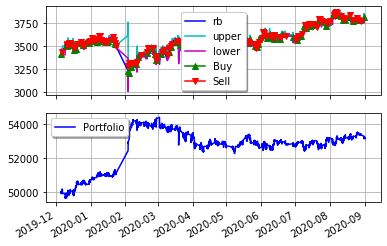

In [143]:
main()

## 模型优化

- 量化模型优化的两个着手点
    - 样本数据的选择
    - 模型参数的选择

### 样本数据选择

- 样本数据的回测效果受到两个方面的影响
    - 宏观层面：周期性波动
    - 微观层面：数据波动性的变化

#### 周期性波动

<center><img src="./img/performance/cycleTheory.jpg" width=100%></center>

<center><img src="./img/performance/cycles.png" width=100%></center>

<center><img src="./img/performance/cu.PNG" width=100%></center>

- 铜（cu）期货的周线数据

#### 波动性变化

- 股指期货保证金、手续费增加的影响

<center><img src="./img/performance/ifMargin.jpg" width=100%></center>

<center><img src="./img/performance/if.PNG" width=100%></center>

#### 样本内外数据的划分

- 历史基准法
    - 将距离当前较远的数据作为样本内数据，进行回测，再利用距离当前较近的数据检验

- 当前基准法
    - 将距离当前最近的一段数据作为样本内数据，进行回测，再利用距离当前较远的数据检验

- 中间基准法
    - 利用中间段的数据进行回测，再利用两段de

### 最优参数选择

- 直接优化法
    - 设定目标函数
    - 设定参数取值范围**组合**

#### 参数的搜索空间

- 例如：基于布林线的均值回归策略

- 两个参数，布林线上下界时间窗口、中线离上下界的距离（标准差的倍数）

In [220]:
paraTup = []
for each in range(20,70,5):
    for num in np.linspace(0.5,4,8):
        paraTup.append((each,num))
print(paraTup)

[(20, 0.5), (20, 1.0), (20, 1.5), (20, 2.0), (20, 2.5), (20, 3.0), (20, 3.5), (20, 4.0), (25, 0.5), (25, 1.0), (25, 1.5), (25, 2.0), (25, 2.5), (25, 3.0), (25, 3.5), (25, 4.0), (30, 0.5), (30, 1.0), (30, 1.5), (30, 2.0), (30, 2.5), (30, 3.0), (30, 3.5), (30, 4.0), (35, 0.5), (35, 1.0), (35, 1.5), (35, 2.0), (35, 2.5), (35, 3.0), (35, 3.5), (35, 4.0), (40, 0.5), (40, 1.0), (40, 1.5), (40, 2.0), (40, 2.5), (40, 3.0), (40, 3.5), (40, 4.0), (45, 0.5), (45, 1.0), (45, 1.5), (45, 2.0), (45, 2.5), (45, 3.0), (45, 3.5), (45, 4.0), (50, 0.5), (50, 1.0), (50, 1.5), (50, 2.0), (50, 2.5), (50, 3.0), (50, 3.5), (50, 4.0), (55, 0.5), (55, 1.0), (55, 1.5), (55, 2.0), (55, 2.5), (55, 3.0), (55, 3.5), (55, 4.0), (60, 0.5), (60, 1.0), (60, 1.5), (60, 2.0), (60, 2.5), (60, 3.0), (60, 3.5), (60, 4.0), (65, 0.5), (65, 1.0), (65, 1.5), (65, 2.0), (65, 2.5), (65, 3.0), (65, 3.5), (65, 4.0)]


In [189]:
def main(bBandsPeriod, numDev):
    instrument = 'rb'
    feed = read_data(instrument)
    
    strat = myBBands(feed, instrument, bBandsPeriod, numDev, 50000)
    
    retEval, sharpeEval, ddEval, tradesEval = strategy_evaluation(strat)
    
    stratPlt = strategy_plot(strat, instrument)
    
    strat.run()
    
    sharpe = sharpeEval.getSharpeRatio(0.03)
    print(f'Sharpe Ratio为：{sharpe}')
    return sharpe

In [196]:
class myBBands(strategy.BacktestingStrategy):
    
    def __init__(self, feed, instrument, bBandsPeriod, numDev, initEquity):
        super(myBBands, self).__init__(feed, initEquity)
        self.__instrument = instrument
        self.__bbands = bollinger.BollingerBands(feed[instrument].getCloseDataSeries(), bBandsPeriod, numDev)
        self.__positivePosition = None
        self.__negativePosition = None

    def getBollingerBands(self):
        return self.__bbands
    
    def onExitOk(self, position):
#         order = position.getExitOrder()
#         execInfo = order.getExecutionInfo()
#         self.info(f'{self.action_type(order)}，价格为{execInfo.getPrice():.2f}')
        if self.__negativePosition == position:
            self.__negativePosition = None
        elif self.__positivePosition == position:
            self.__positivePosition = None
        
#     def onEnterOk(self, position):
#         order = position.getEntryOrder()
#         execInfo = order.getExecutionInfo()
#         self.info(f'{self.action_type(order)}，价格为{execInfo.getPrice():.2f}')
        
    def action_type(self, order):
        actionType = order.getAction()
        typeMeaning = ''
        if actionType == 1:
            typeMeaning = '建多仓'
        elif actionType == 2:
            typeMeaning = '平空仓'
        elif actionType == 3:
            typeMeaning = '平多仓'
        elif actionType == 4:
            typeMeaning = '建空仓'
        return typeMeaning
            

    def onBars(self, bars):
        lower = self.__bbands.getLowerBand()[-1]
        upper = self.__bbands.getUpperBand()[-1]
        if lower is None:
            return

        bar = bars[self.__instrument]
        
        if bar.getClose() < lower:
            if self.__negativePosition is not None and self.__negativePosition.exitActive() is False:
                # 有空仓，并且没有平空仓的挂单
                self.__negativePosition.exitMarket()
            if self.__positivePosition is None:
                # 没有多仓
                self.__positivePosition = self.enterLong(self.__instrument, 5)
        elif bar.getClose() > upper:
            if self.__positivePosition is not None and self.__positivePosition.exitActive() is False:
                # 有多仓，并且没有平多仓的挂单
                self.__positivePosition.exitMarket()
            if self.__negativePosition is None:
                # 没有空仓
                self.__negativePosition = self.enterShort(self.__instrument, 5)

In [221]:
resLst = []
for period, num in paraTup:
    resLst.append(main(period,num))

Sharpe Ratio为：2.2108375379817136
Sharpe Ratio为：0.23014163745987642
Sharpe Ratio为：0.0601307076066334
Sharpe Ratio为：2.3831086230801923
Sharpe Ratio为：1.3065758045980598
Sharpe Ratio为：0.1317123033445212
Sharpe Ratio为：0.1459775249238472
Sharpe Ratio为：0.4831753455835114
Sharpe Ratio为：1.1839954520962772
Sharpe Ratio为：-0.1836059468433718
Sharpe Ratio为：0.8154530206953502
Sharpe Ratio为：2.086549705863651
Sharpe Ratio为：0.2328843341226429
Sharpe Ratio为：-0.3557723012633172
Sharpe Ratio为：-0.4982360519192234
Sharpe Ratio为：-0.07413991120395261
Sharpe Ratio为：1.079403240877296
Sharpe Ratio为：-0.30965471652390403
Sharpe Ratio为：0.44193765986028777
Sharpe Ratio为：0.6408586485076859
Sharpe Ratio为：-0.16556952064875316
Sharpe Ratio为：0.7399482044921095
Sharpe Ratio为：0.08910461625292304
Sharpe Ratio为：-0.6895469555136364
Sharpe Ratio为：0.8577280900937782
Sharpe Ratio为：-0.6730735417233424
Sharpe Ratio为：1.4090223753077256
Sharpe Ratio为：1.0548175119022398
Sharpe Ratio为：-0.4483849687969193
Sharpe Ratio为：-0.4474562954127

<IPython.core.display.Javascript object>


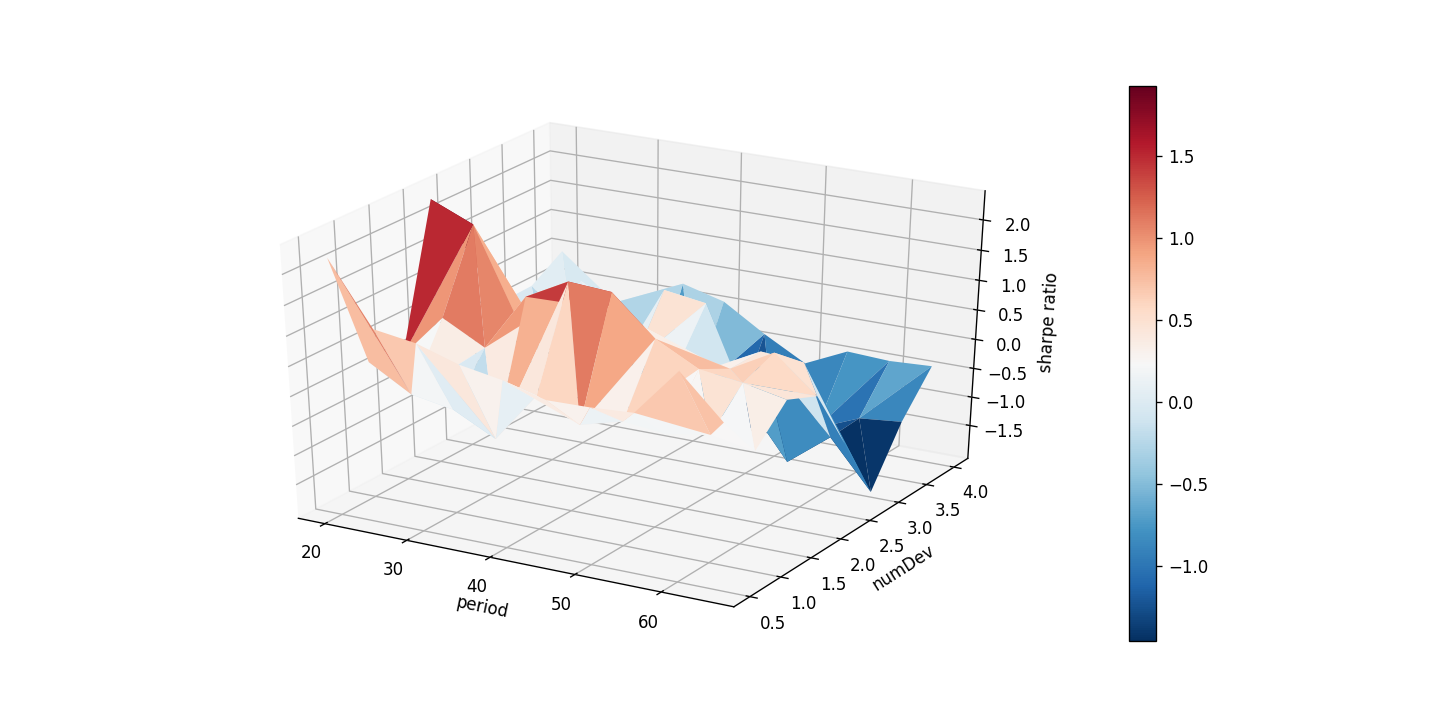

[Text(0.5, 0, 'sharpe ratio'), Text(0.5, 0, 'numDev'), Text(0.5, 0, 'period')]

In [223]:
%matplotlib notebook
import matplotlib.tri as mtri
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,1,1, projection='3d')
x = [each[0] for each in paraTup]
y = [each[1] for each in paraTup]
triag = mtri.Triangulation(x,y)
surf = ax.plot_trisurf(triag,resLst,cmap="RdBu_r")
ax.set(xlabel='period',ylabel='numDev',zlabel='sharpe ratio')
fig.colorbar(surf,ax=ax)

#### 选什么样的参数？

- 一个策略的目标函数值随着参数取值的变化

<center><img src="./img/performance/plateau.PNG" width=100%></center>

- 选择B点作为最优参数

- B点位于参数**高原**(plateau)的中心，参数的可靠性高

- D点是一个参数**孤岛**，可能是过度拟合导致的